In [17]:
import numpy as np
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
%matplotlib inline
import os
import geopandas as gpd
from mpl_toolkits.mplot3d import Axes3D
from geopy.geocoders import Nominatim
import folium

In [68]:
address = 'Sint-Paulusstraat 22, 2000 Antwerpen'#'Andreas Vesaliusstraat 13 3000 Leuven ' #'Kardinaal Mercierlaan 94, 3001 Leuven' #'Jozef Vandaleplein, 8500 Kortrijk', 'Sint-Paulusstraat 22, 2000 Antwerpen'#
df = gpd.tools.geocode(address)
df

geometry                                            address
0  POINT (4.40138 51.22394)  Sint-Pauluskerk, 22, Sint-Paulusstraat, 2000, ...

In [69]:
# Locate the coresponding Tiff file where the address lies
import pandas as pd
df = pd.read_csv('Data/bound_data.csv', '\t')
del df['Unnamed: 0']
df = df.set_index('i')

/home/mokegg/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning:

In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only



In [70]:
#Obtain the coordinates of the area of interset in CRS = epsg:31370
from geopy.geocoders import Nominatim #Geolocator
import pyproj #Transformer
geolocator = Nominatim(user_agent="Moke", timeout=2)
location = geolocator.geocode(address)
x,y = (location.latitude, location.longitude) #Location in CRS = epsg:4326

#Transform the CRS
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:31370")
X,Y = transformer.transform(x, y)
X,Y


#Find the index of the rasterfile

df = df[(df['left'] <= X) & (X <= df['right'])]
df = df[(df['bottom'] <= Y) & (Y <= df['top'])]
# print(df)

# df[((df['left'] <= X) & (X <= df['right'])) & ((df['bottom'] <= Y) & (Y <= df['top']))]

i = df.index.item()


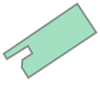

In [71]:
from shapely.geometry import Point, LineString, Polygon
from bs4 import BeautifulSoup
import requests 
def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    points = info['polygon'][0]['coordinates'][0] 
    return points #info['polygon'][0]['coordinates'][0] 

pointList = get_coordinates(address)
pointList
poly = Polygon([[p[0], p[1]] for p in pointList])

# print(poly.wkt) 
# pointList
poly

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        , 15.95583057, 16.06011724,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , 14.14668608,
         17.44616747, 16.82251978, 16.36527109,  1.75741577,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,

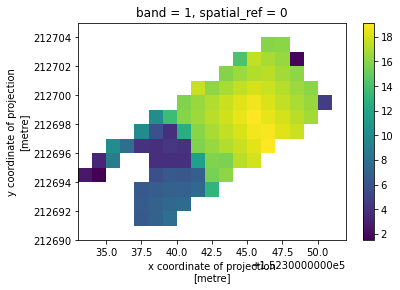

In [115]:
import rioxarray as rxr
# geometry = poly
geometries = [{'type': 'Polygon','coordinates': [pointList]}]
DSM = rxr.open_rasterio(f'zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k{i}.zip!/GeoTIFF/DHMVIIDSMRAS1m_k{i}.tif', masked=True)

# DSM = rxr.open_rasterio("./Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif", masked=True)
clipped_DSM = DSM.rio.clip(geometries, from_disk = True)
# clipped_DSM.plot() 

DTM = rxr.open_rasterio(f'zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k{i}.zip!/GeoTIFF/DHMVIIDTMRAS1m_k{i}.tif', masked=True)
clipped_DTM = DTM.rio.clip(geometries, from_disk = True)
# clipped_DTM.plot() 

clipped_CHM = clipped_DSM - clipped_DTM
clipped_CHM.plot() 

a = clipped_CHM

clipped_CHM = np.where(np.isnan(a), 0, a)
clipped_CHM

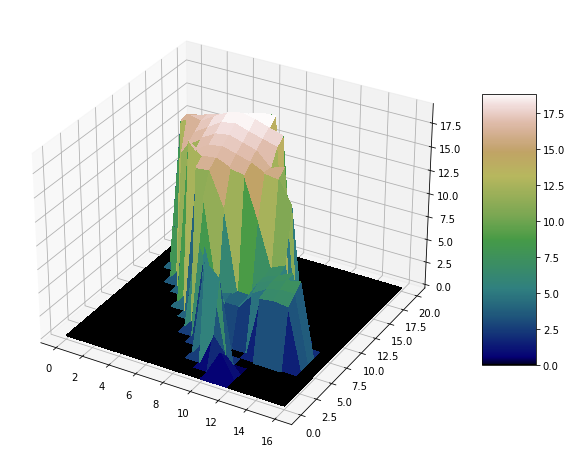

In [117]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(x,y,z, cmap='gist_earth',linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
# ax.plot_wireframe(x,y,z)
# plt.figure()
# plt.scatter(x, y, z)
plt.show()

In [126]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
X1,Y1 = clipped_CHM[0].shape
x = range(X1+2)
y = range (Y1+2)
x,y = np.meshgrid(x, y, indexing='ij')

z = clipped_CHM[0]

z = np.pad(z, 1, mode='constant')
z.shape
x.shape, y.shape, z.shape

import mayavi
from mayavi import mlab

# mlab.init_notebook()
# mlab.figure(size=(250, 250), bgcolor=(0.16, 0.28, 0.46))
mlab.mesh(x,y,z)#, warp_scale=1) 
mlab.show()

In [103]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=z)])
fig.show()

In [10]:
#Use Fiona to create the shape file
import fiona
import pandas as pd
# define schema
schema = {
    'geometry':'Polygon',
    'properties':[('Name','str')]
}
#open a fiona object
polyShp = fiona.open('./Data/cropPoly.shp', mode='w', driver='ESRI Shapefile',
          schema = schema, crs = "EPSG:31370")

rowDict = {
'geometry' : {'type':'Polygon',
                 'coordinates': [pointList]}, #Here the xyList is in brackets
'properties': {'Name' : ''},
}
polyShp.write(rowDict)
#close fiona object
polyShp.close()

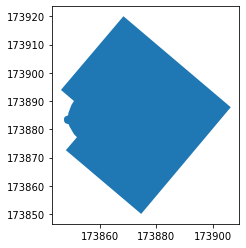

Name                                           geometry
0  None  POLYGON ((173880.602 173909.679, 173906.391 17...

In [11]:
#Read Shape files
shape_df = gpd.read_file('Data/cropPoly.shp')
# x0 = shape_df.loc[1, 'geometry']
# x0
shape_df.crs
# print(shape_df.crs)
shape_df.head()

shape_df.plot()
plt.show()
shape_df

In [12]:
# #intersecting
# Building = gpd.overlay(src, shape_df, how = 'intersection')

In [13]:
#Open and read the dsm and dtm raster files the shapefile
window = rasterio.windows.Window(X-1000,Y-1000,X+1000,Y+1000)

with rasterio.open('Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    subset = src.read(1, window=window)
    out_meta = src.meta
    count = src.count
out_meta.update({"driver": "GTiff",
             "height": subset.shape[0],
             "width": subset.shape[1]})


DSM = rxr.open_rasterio("./Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif", window=window, masked=True).squeeze()
DTM = rxr.open_rasterio('./Data/DTM_Data/DHMVIIDTMRAS1m_k32.tif', window=window, masked=True).squeeze()
DSM-DTM


# Read the shapefile
crop_extent = gpd.read_file("./Data/cropPoly.shp")

#check CRS
# print('dsm: ', dsm.rio.crs)
# print('dsm: ', dtm.rio.crs)
# print('aoi: ', crop_extent.crs)



NameError: name 'shapes' is not defined

In [ ]:
DSM.shape

In [ ]:
# type(DSM)
# DSM.shape
# CHM = DSM - DTM

In [ ]:
# DSM.shape
# DTM.shape

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

crop_extent.plot(ax=ax)

ax.set_title("Shapefile Crop Extent",
             fontsize=16)
plt.show()

In [ ]:
#Use shapely to clip the Geotiff and the shapefile of the House

from shapely.geometry import mapping
# f, ax = plt.subplots(figsize=(10, 5))
# dsm.plot.imshow(ax=ax)

# crop_extent.plot(ax=ax,
#                  alpha=.8)
# ax.set(title="Raster Layer with Shapefile Overlayed")

# ax.set_axis_off()
# plt.show()

# dsm_lidar_clipped = dsm.rio.clip(crop_extent.geometry.apply(mapping))#
lidar_clipped = DSM.rio.clip(crop_extent.geometry.apply(mapping))
# f, ax = plt.subplots(figsize=(10, 4))
# lidar_clipped.plot(ax=ax)
# ax.set(title="Raster Layer Cropped to Geodataframe Extent")
# ax.set_axis_off()
# plt.show()

In [ ]:
#Show the clipped Geotiff

f, ax = plt.subplots(figsize=(10, 4))
lidar_clipped.plot(ax=ax)
ax.set(title="Raster Layer Cropped to Geodataframe Extent")
ax.set_axis_off()
plt.show()

In [ ]:
#Save the clipped Geotiff to file
lidar_clipped.rio.to_raster(f"./Data/{address}.tif")

In [ ]:
# clipped_chm = rxr.open_rasterio(f"./Data/{address}.tif")
DSM_img = rasterio.open(f"./Data/{address}.tif", masked=True)
DSM_arr = DSM_img.read()
X,Y = DSM_arr[0].shape

X



# # Customize your plot as you wish!
# f, ax = plt.subplots(figsize=(10, 4))
# clipped_chm.plot(ax=ax,
#                  cmap='Greys')
# ax.set(title="Final Clipped CHM")
# ax.set_axis_off()
# plt.show()

In [ ]:
#3D plot the House

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate

x= range(X)
y = range (Y)
x,y = np.meshgrid(x, y, indexing='ij')

z = DSM_arr[0]



z.shape
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(x,y,z)#, cmap='gist_earth',linewidth=0, antialiased=False)
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
# ax.plot_wireframe(x,y,z)
# plt.figure()
# plt.scatter(x, y, z)
plt.show()

In [ ]:
xnew, ynew = np.mgrid[range(250), range(250)]
tck = interpolate.bisplrep(x, y, z, s=0)
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(xnew,ynew,znew)#,cmap='jet',linewidth=0, antialiased=False)
# ax.plot_wireframe(x,y,z)
# plt.figure()
# plt.scatter(x, y, z)
plt.show()